In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import dataset

In [ ]:
file_path = '/content/drive/MyDrive/captcha-dataset'

In [ ]:
label = []
label = os.listdir(file_path)

img_path = []
for i in label:
  img_path.append(file_path + '/' + i)  

In [ ]:
df = pd.DataFrame()
df['img_path'] = img_path
df['label'] = label
df['label'] = df['label'].str.split('.').str[0]

In [ ]:
df.head()

,img_path,label
0,/content/drive/MyDrive/captcha-dataset/377xx.png,377xx
1,/content/drive/MyDrive/captcha-dataset/3ny45.png,3ny45
2,/content/drive/MyDrive/captcha-dataset/3eny7.png,3eny7
3,/content/drive/MyDrive/captcha-dataset/36bc2.png,36bc2
4,/content/drive/MyDrive/captcha-dataset/43xfe.png,43xfe


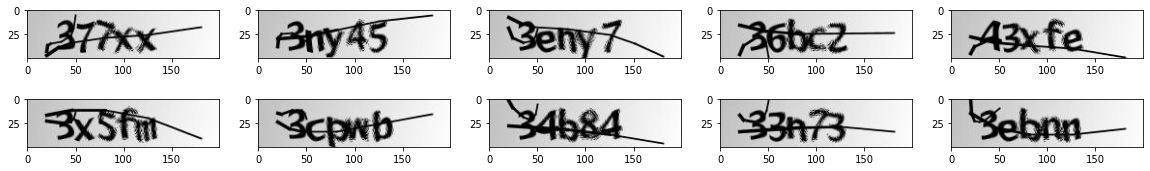

In [ ]:
plt.figure(figsize=(20, 3))
for i, e in enumerate(df['img_path'][0:10]):
  sample_img = cv2.imread(e, 0)
  plt.subplot(2, 5, i+1)
  plt.imshow(sample_img, cmap='gray')

#Label encoding

In [ ]:
char_to_num = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'm': 13, 'n': 14, 'p': 15, 'w': 16, 'x': 17, 'y': 18}
num_to_char = {'0':'2', '1':'3', '2':'4', '3':'5', '4':'6', '5':'7', '6':'8', '7':'b', '8':'c', '9':'d', '10':'e', '11':'f', '12':'g', '13':'m', '14':'n', '15':'p', '16':'w', '17':'x', '18':'y'}

In [ ]:
encoded_label = []
for i in df['label']:
  encoded_label.append(list(map(lambda x: char_to_num[x], list(i))))

df['encoded_label'] = encoded_label

In [ ]:
df.head()

,img_path,label,encoded_label
0,/content/drive/MyDrive/captcha-dataset/377xx.png,377xx,"[1, 5, 5, 17, 17]"
1,/content/drive/MyDrive/captcha-dataset/3ny45.png,3ny45,"[1, 14, 18, 2, 3]"
2,/content/drive/MyDrive/captcha-dataset/3eny7.png,3eny7,"[1, 10, 14, 18, 5]"
3,/content/drive/MyDrive/captcha-dataset/36bc2.png,36bc2,"[1, 4, 7, 8, 0]"
4,/content/drive/MyDrive/captcha-dataset/43xfe.png,43xfe,"[2, 1, 17, 11, 10]"


#Preprocess

In [ ]:
img = []

for i in df['img_path']:
  image = cv2.imread(i, 0)
  cropped = image[10:50, 25:150]
  dilated = cv2.dilate(cropped, None, iterations=1)
  thresh = cv2.threshold(dilated, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  #rotated = tf.transpose(dilated, perm=[1, 0])
  #blur = cv2.medianBlur(cropped, 5)
  #gauss = cv2.adaptiveThreshold(blur ,255 , cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
  rotated = cv2.rotate(thresh, cv2.ROTATE_90_CLOCKWISE)

  img.append(rotated)

In [ ]:
img = np.array(img)

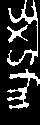

In [ ]:
cv2_imshow(img[5])

In [ ]:
img_normalized = img.astype('float32')/255 # Normalize

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img_normalized, encoded_label, test_size = 0.2, random_state = 42)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print('Train_set Feature shape: %s'%str(x_train.shape))
print('Test_set Feature shape: %s'%str(x_test.shape))

Train_set Feature shape: (856, 125, 40)
Test_set Feature shape: (214, 125, 40)


#Model training

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

In [ ]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(125,40,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(5, 3968), name="reshape")(x)

    # FC layers
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu", name="dense2")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu", name="denseX")(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="classifier_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 125, 40, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 125, 40, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 62, 20, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 62, 20, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 31, 10, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 3968)           0         
                                                                 
 dropout_38 (Dropout)        (None, 5, 3968)      

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
save_path = '/content/weight_improvement/ocr_{epoch:02d}_{val_accuracy:.2f}.hdf5'

In [ ]:
checkpoint = ModelCheckpoint(save_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x_train, y_train, validation_split = 0.2, epochs=150, callbacks = callbacks_list)

Epoch 1/150
21/22 [===========================>..] - ETA: 0s - loss: 3.3721 - accuracy: 0.0604
Epoch 1: val_accuracy improved from -inf to 0.07558, saving model to /content/weight_improvement/ocr_01_0.08.hdf5
22/22 [==============================] - 1s 29ms/step - loss: 3.3647 - accuracy: 0.0605 - val_loss: 2.9370 - val_accuracy: 0.0756
Epoch 2/150
18/22 [=======================>......] - ETA: 0s - loss: 2.9403 - accuracy: 0.0642
Epoch 2: val_accuracy improved from 0.07558 to 0.11163, saving model to /content/weight_improvement/ocr_02_0.11.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 2.9379 - accuracy: 0.0632 - val_loss: 2.9327 - val_accuracy: 0.1116
Epoch 3/150
18/22 [=======================>......] - ETA: 0s - loss: 2.9300 - accuracy: 0.0858
Epoch 3: val_accuracy improved from 0.11163 to 0.11279, saving model to /content/weight_improvement/ocr_03_0.11.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 2.9288 - accuracy: 0.0883 - val_loss: 2.9210 

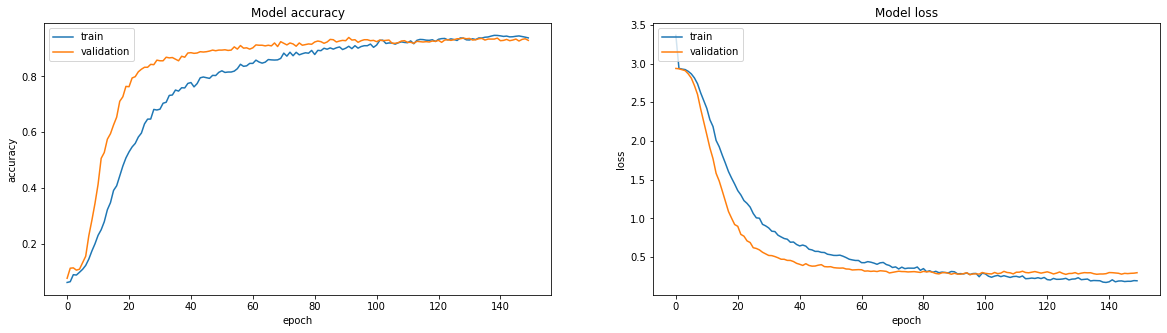

In [ ]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
#plt.plot(history.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
      return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])  
    else:
      raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

In [ ]:
y_pred = model.predict(x_test)

7/7 [==============================] - 0s 5ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=2)

In [ ]:
compute_perf_metric(y_pred, y_test)

0.9411214953271028

In [ ]:
prediction = []
actual = []
for i in range(y_test.shape[0]):
  for j in range(5):
    prediction.append(list(y_pred[i])[j])
    actual.append(list(y_test[i])[j])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
char = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']

In [ ]:
print('Accuracy : ' + str(accuracy_score(actual, prediction)))
print(classification_report(actual, prediction, target_names = char))

Accuracy : 0.9411214953271028
              precision    recall  f1-score   support

           2       0.94      0.96      0.95        48
           3       0.96      0.96      0.96        48
           4       0.94      0.96      0.95        50
           5       0.92      0.98      0.95        61
           6       0.93      0.95      0.94        55
           7       0.95      0.96      0.95        54
           8       0.91      0.96      0.93        51
           b       0.96      0.90      0.93        58
           c       0.92      0.92      0.92        65
           d       0.98      0.92      0.95        51
           e       0.98      0.88      0.93        59
           f       0.95      0.98      0.97        63
           g       1.00      0.90      0.95        51
           m       0.82      0.90      0.86        51
           n       0.90      0.93      0.92       101
           p       0.91      1.00      0.96        43
           w       1.00      0.96      0.98        

In [ ]:
img_test = x_test*255

In [ ]:
img_test.shape

(214, 125, 40)

In [ ]:
rotate_test = []
for i in range(214):
  rotate_test.append(cv2.rotate(img_test[i], cv2.ROTATE_90_COUNTERCLOCKWISE))

In [ ]:
import math
from matplotlib.pyplot import figure

In [ ]:
list(map(lambda x: char_to_num[x], list(i)))

In [ ]:
def show_false_prediction(pred, train, test, channel=1):
  false_index = []
  for i,e in enumerate(pred):
    if np.sum(e == test[i]) != 5:
      false_index.append(i)

  count = -1
  rows = math.ceil(len(false_index)/5)

  fig, ax = plt.subplots(rows, 5, figsize=(24, 48))
  plt.subplots_adjust(hspace=0.05)
  for i in range(rows):
    for j in range(5):
      count += 1
      predicted = pred[false_index[count]]
      predicted = list(map(lambda x: num_to_char[str(x)], list(predicted)))
      actual = test[false_index[count]]
      actual = list(map(lambda x: num_to_char[str(x)], list(actual)))
      ax[i,j].imshow(train[false_index[count]], cmap='gray')
      ax[i,j].set_title('Predict %s\nActual %s'%(predicted, actual))

In [ ]:
np.sum(y_pred[1] == y_test[1])

5

In [ ]:
list(map(lambda x: num_to_char[str(x)], list(y_pred[1])))

['m', 'g', 'd', 'w', 'b']

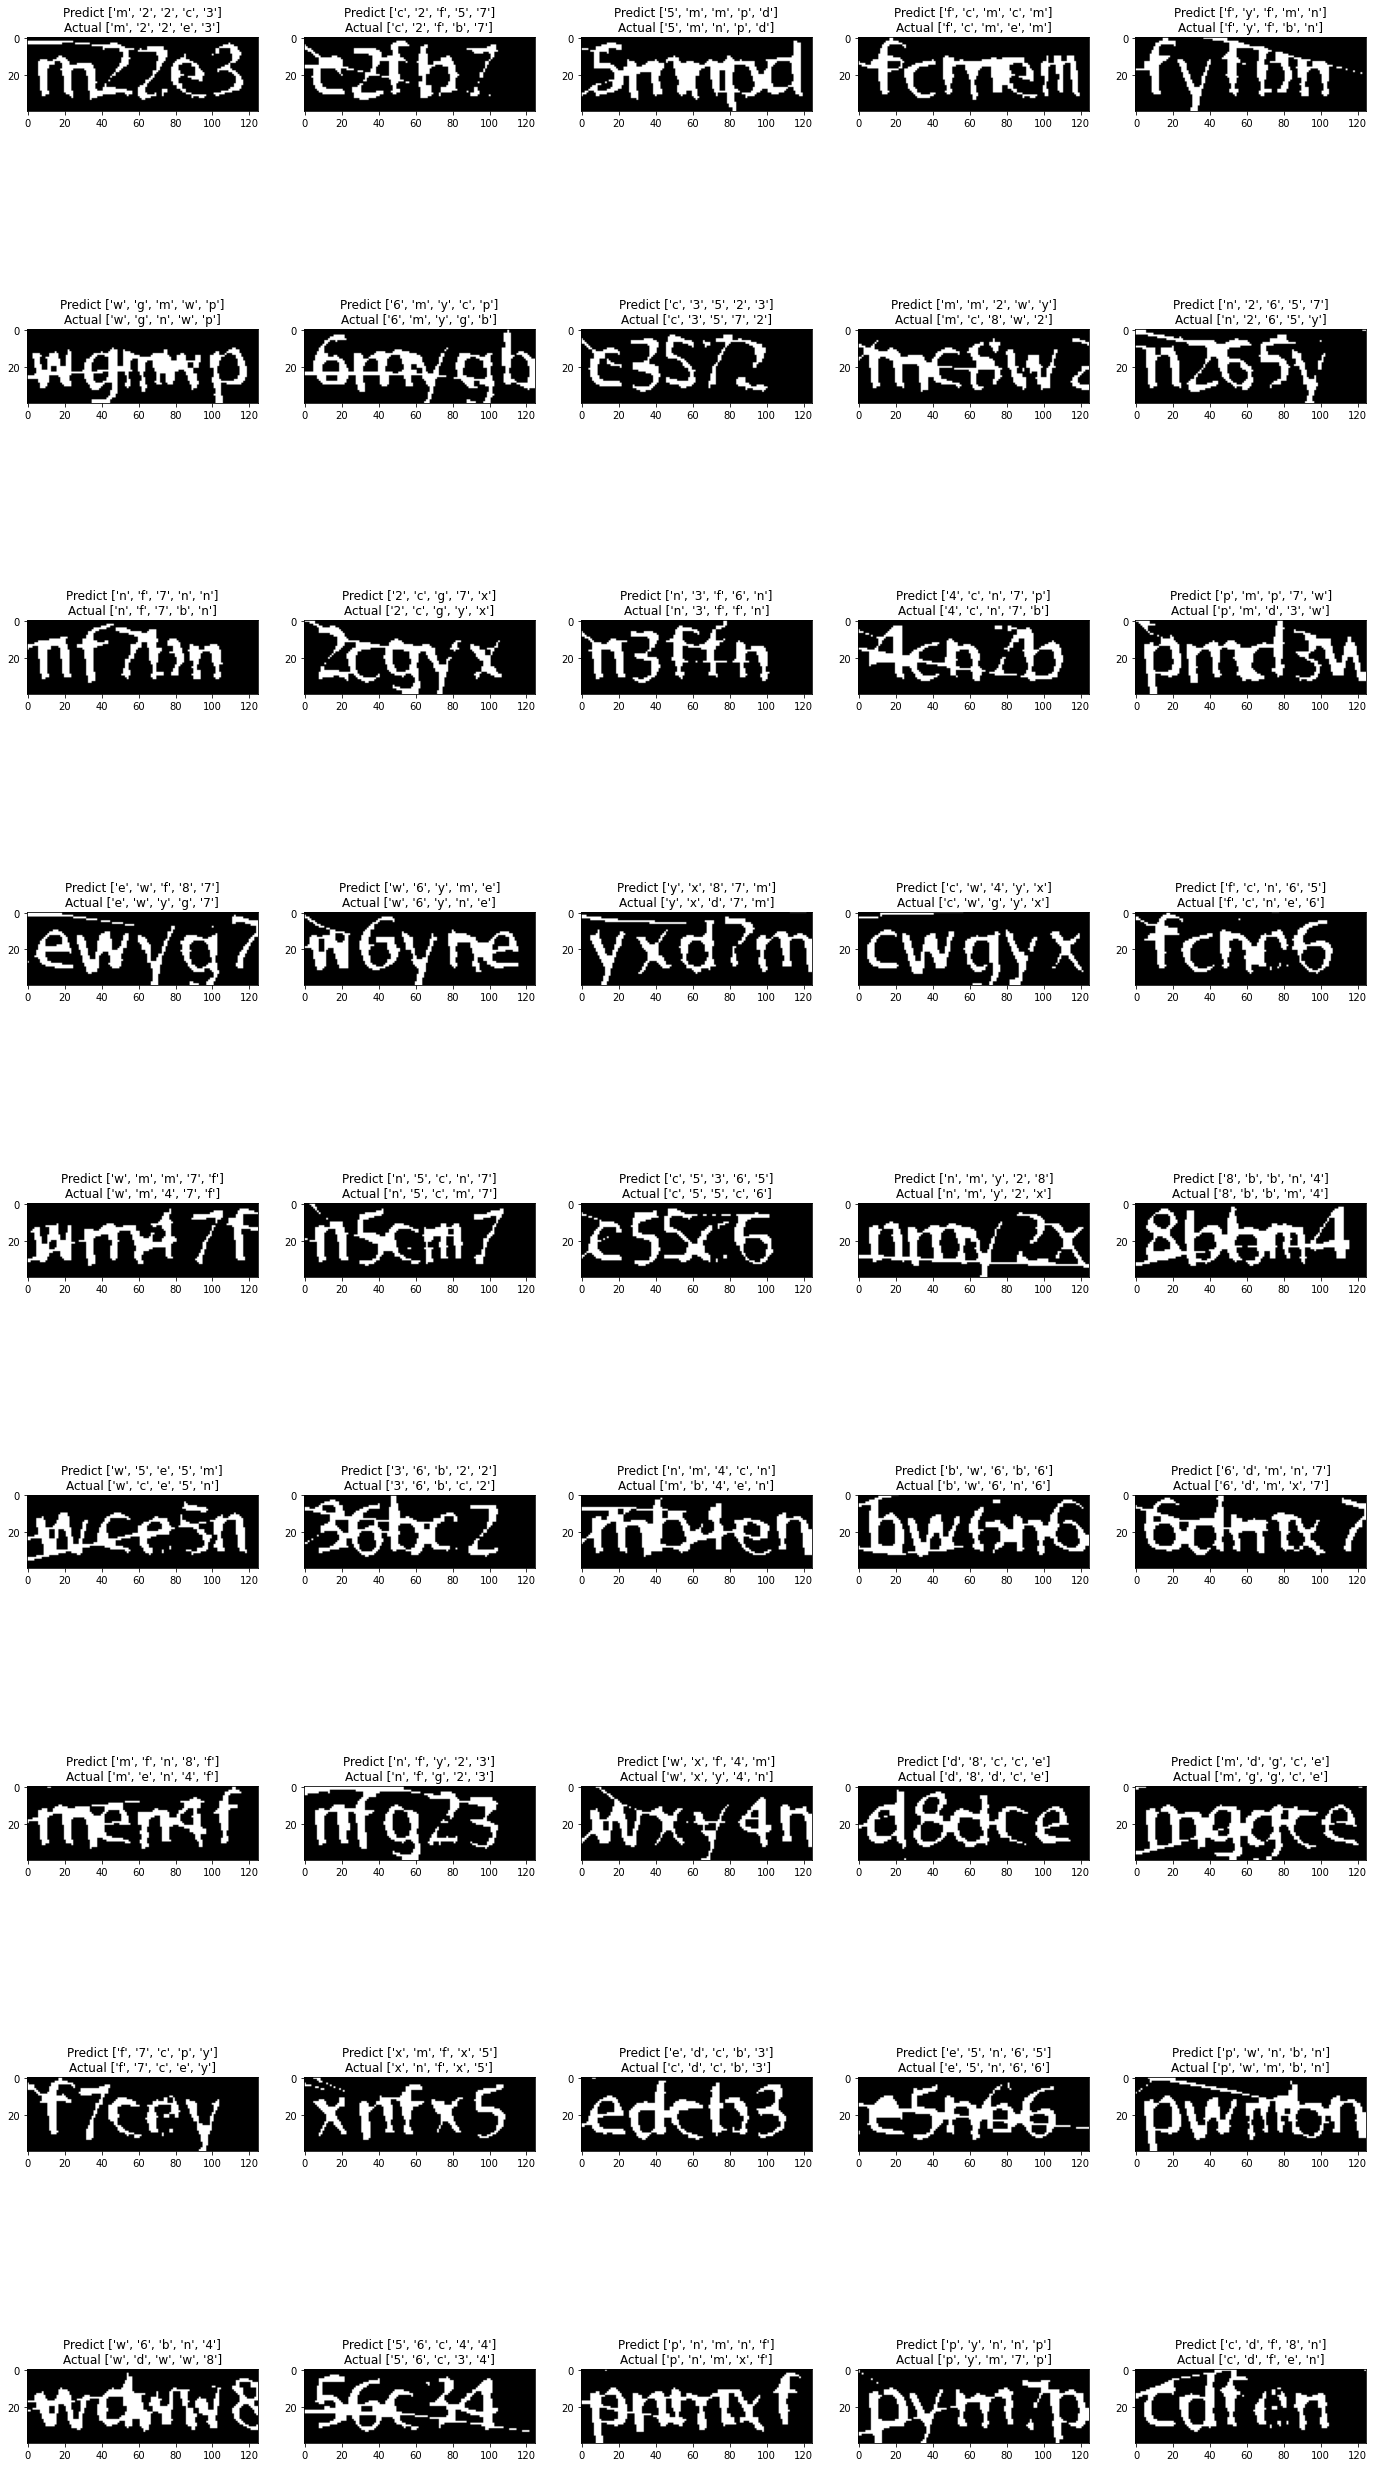

In [ ]:
show_false_prediction(y_pred, rotate_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(actual, prediction))

[[46  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 46  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 52  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  1  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 52  0  0  0  0  0  2  1  2  0  0  0]
 [ 1  0  0  1  1  0  0  0 60  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  1 47  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  1  0  3  0 52  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 62  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  1  1  0  0 46  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 46  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  6 94  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 43  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0